# Introducción al análisis de series de tiempo
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

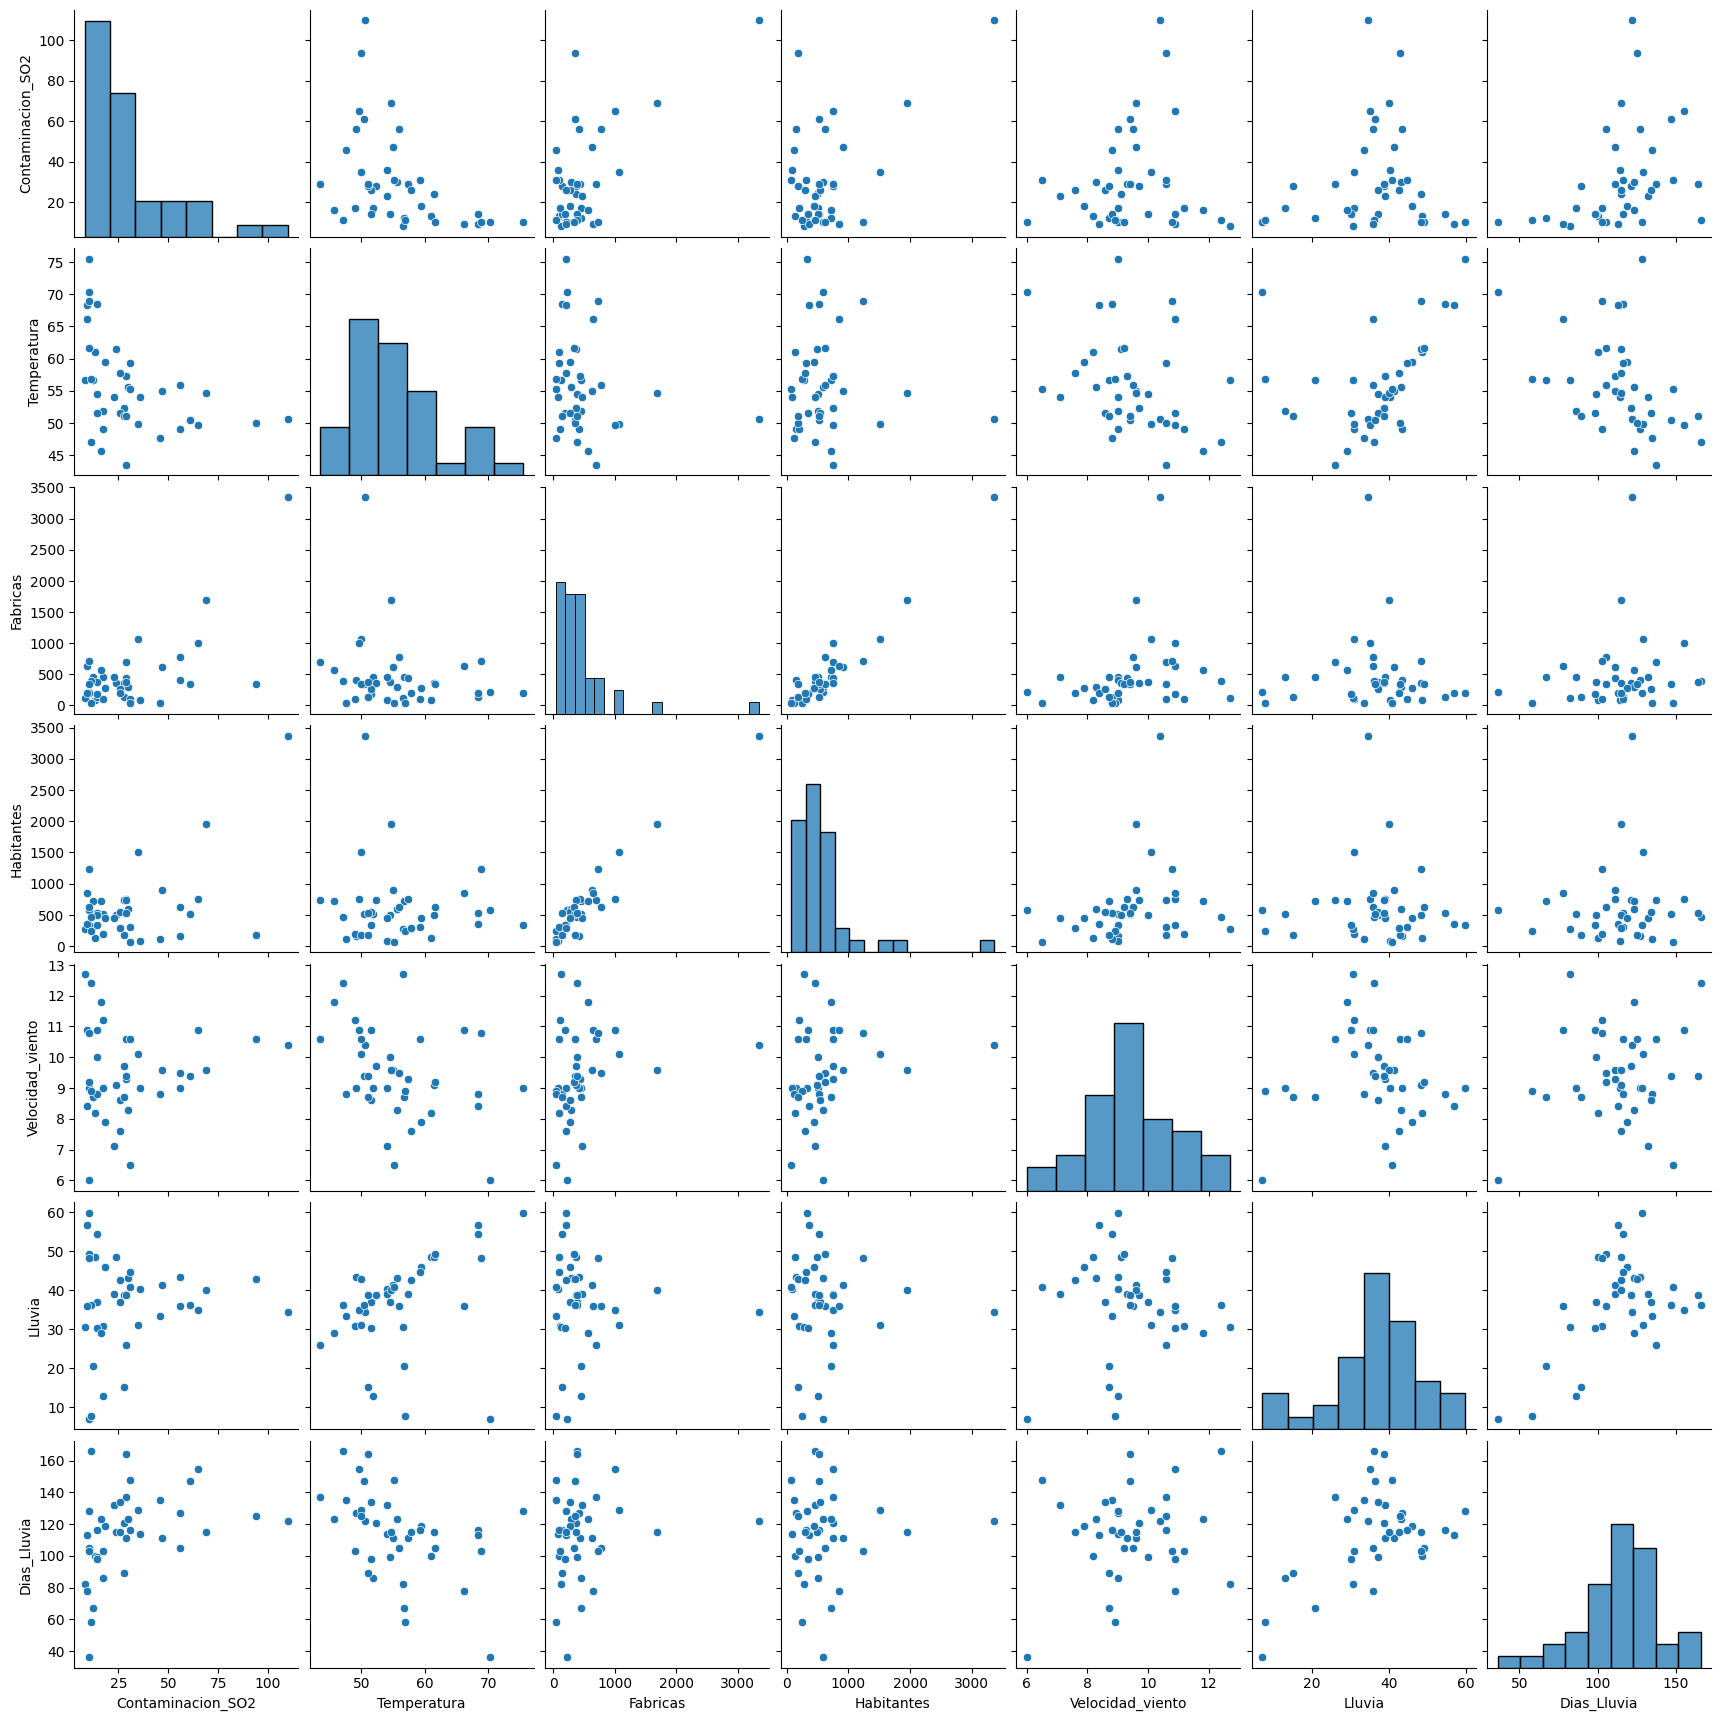

In [2]:
cont = pd.read_csv('https://bit.ly/31B56KB')
# cont.info()
sns.pairplot(cont)

Nótese no existe correlación normal (Pues aunado a la poca cantidad de datos que se tiene, los histogramas parecen no seguir una distribución normal). Por ende, es conveniente usar el coeficiente de correlación de Spearman:

<Axes: >

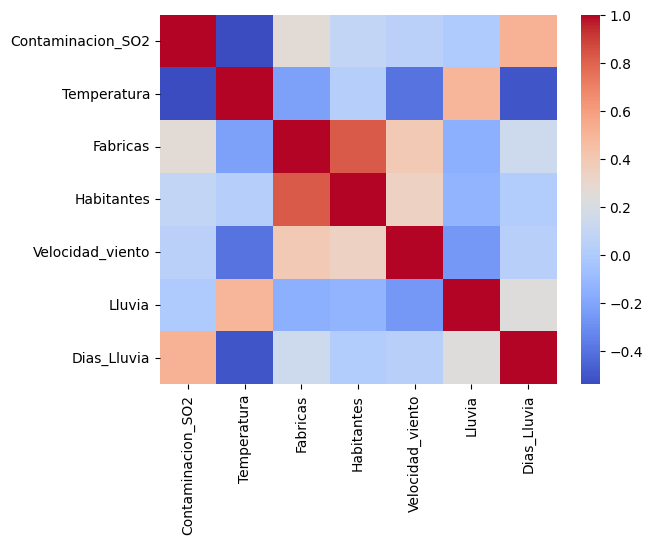

In [3]:
cont_corr = cont.corr(method = 'spearman')
# cont_corr
sns.heatmap(cont_corr, cmap = 'coolwarm', xticklabels = cont_corr.columns, yticklabels = cont_corr.columns)

In [4]:
# Verificar significancia
!pip install pingouin

In [5]:
import pingouin as pg
corr = pg.pairwise_corr(cont, method = 'spearman')
# Ordenar por significancia (p-unc)
corr.sort_values(by = ['p-unc'])[['X', 'Y', 'r', 'p-unc']]

,X,Y,r,p-unc
11,Fabricas,Habitantes,0.822997,4.020507e-11
0,Contaminacion_SO2,Temperatura,-0.538831,2.784226e-04
5,Contaminacion_SO2,Dias_Lluvia,0.517709,5.270914e-04
10,Temperatura,Dias_Lluvia,-0.505730,7.434618e-04
9,Temperatura,Lluvia,0.498650,9.057623e-04
8,Temperatura,Velocidad_viento,-0.398282,9.906609e-03
12,Fabricas,Velocidad_viento,0.394193,1.076594e-02
15,Habitantes,Velocidad_viento,0.337431,3.096515e-02
1,Contaminacion_SO2,Fabricas,0.264051,9.527256e-02
18,Velocidad_viento,Lluvia,-0.256605,1.053381e-01


Si $p-unc \, > \, 0.05 \Rightarrow$ la correlación se debe al azar. 

In [6]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels as sm
import scipy.stats as scs
# Registrar el método de conversión para fechas
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [7]:
# Conjuntos de datos
ads = pd.read_csv('ads.csv', index_col = ['Time'], parse_dates = ['Time'])
cur = pd.read_csv('currency.csv', index_col = ['Time'], parse_dates = ['Time'])
display(ads.head(2), cur.head(2))

/tmp/ipykernel_626/4088099821.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cur = pd.read_csv('currency.csv', index_col = ['Time'], parse_dates = ['Time'])


,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885


,GEMS_GEMS_SPENT
Time,
2017-05-01,1199436
2017-05-02,1045515


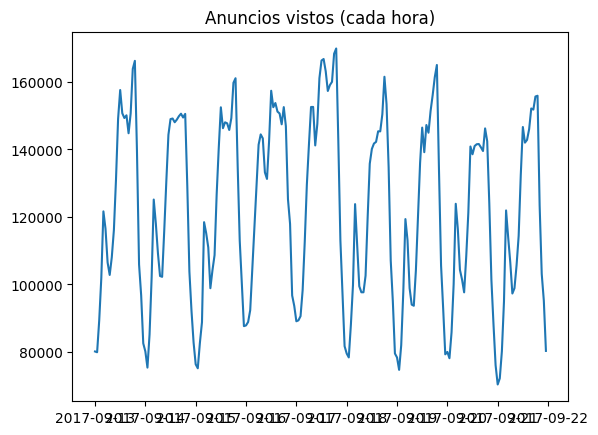

In [8]:
plt.plot(ads.Ads)
plt.title('Anuncios vistos (cada hora)')
plt.show()

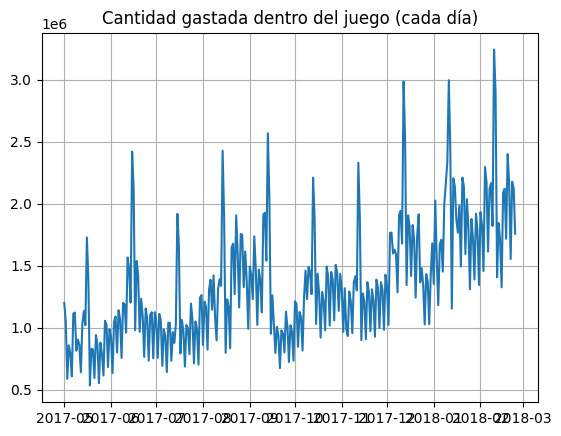

In [9]:
plt.plot(cur.GEMS_GEMS_SPENT)
plt.title('Cantidad gastada dentro del juego (cada día)')
plt.grid(True)
plt.show()

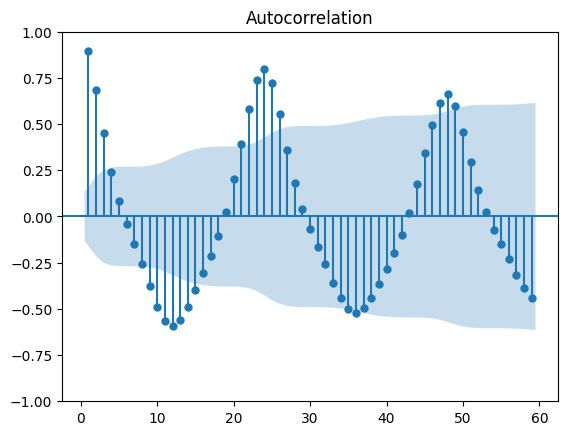

In [10]:
# Autocorrelación
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ads.Ads, lags = range(1, 60), alpha = 0.05)
plt.show()

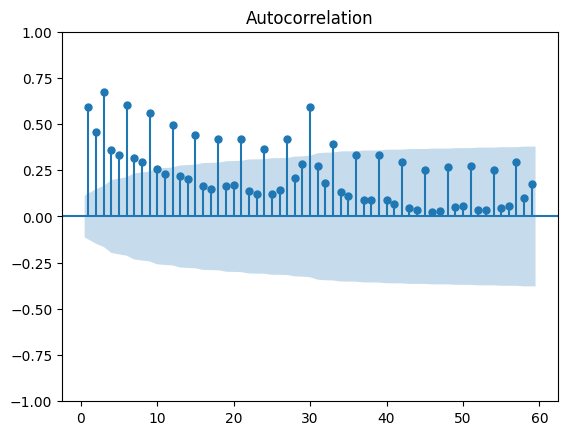

In [11]:
plot_acf(cur.GEMS_GEMS_SPENT, lags = range(1, 60), alpha = 0.05)
plt.show()

In [12]:
# Media movil
def moving_average(serie, n):
    """
    Calcula la media de las 'n' observaciones más recientes
    """
    return np.average(serie[-n:])

moving_average(ads, 24)

np.float64(116805.0)

In [13]:
# Métrica
from sklearn.metrics import mean_absolute_error
def mean_abolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true)) * 100

In [14]:
def plot_moving_average(serie, window, intervalos = False, escala = 2, anomalies = False):
    rolling_mean = serie.rolling(window = window).mean()
    plt.figure(figsize = (12, 5))
    plt.plot(rolling_mean, label = 'Tendencia por media móvil')
    plt.title('Media móvil \n Tamaño de ventana: {}'.format(window))
    if intervalos:
        mae = mean_absolute_error(serie[window:], rolling_mean[window:])
        std = np.std(serie[window:] - rolling_mean[window:])
        low_ = rolling_mean - (mae + escala*std)
        upp_ = rolling_mean + (mae + escala*std)
        plt.plot(upp_, 'r--', label = 'Límites')
        plt.plot(low_, 'r--')
        if anomalies:
            anoms = pd.DataFrame(index = serie.index, columns = serie.columns)
            anoms[serie<low_] = serie[serie<low_]
            anoms[serie>upp_] = serie[serie>upp_]
            plt.plot(anoms, 'ro', markersize = 10)
    plt.plot(serie[window:], label = 'Valores reales')
    plt.legend(loc = 'upper left')
    plt.grid(True)
    plt.show()

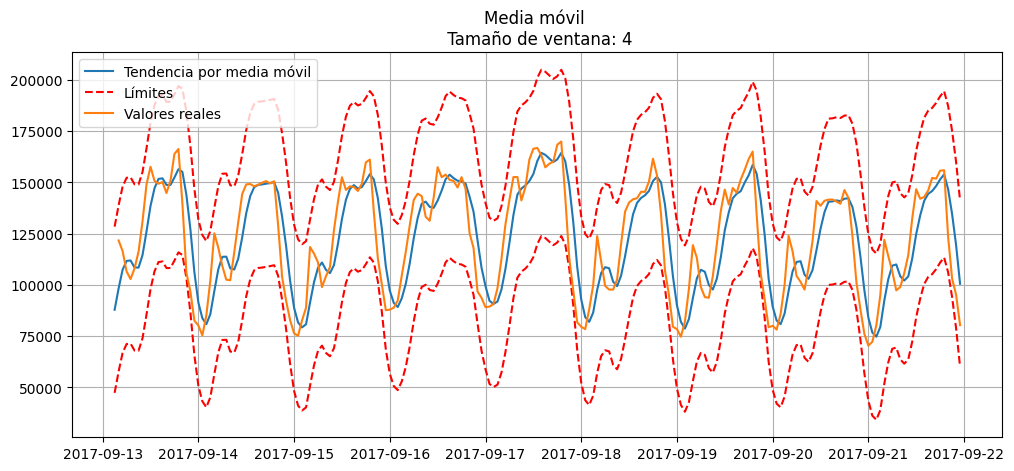

In [15]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

plot_moving_average(ads, 4, intervalos = True, anomalies = True)

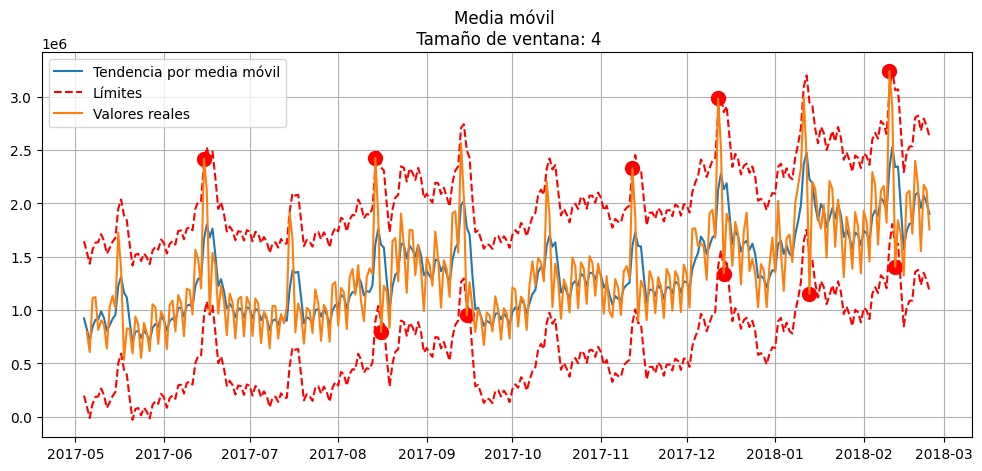

In [16]:
plot_moving_average(cur, 4, intervalos = True, anomalies = True)

In [18]:
def media_pesos(serie, pesos):
    res = 0
    for n in range(len(pesos)):
        res += serie.iloc[-n-1] * pesos[n]
    return res

display(ads.tail(3), media_pesos(ads, [0.6, 0.3, 0.1]))

,Ads
Time,
2017-09-21 21:00:00,103080
2017-09-21 22:00:00,95155
2017-09-21 23:00:00,80285


Ads    87025.5
Name: 2017-09-21 23:00:00, dtype: float64

In [19]:
# Exponencial
def exp_smoothing(serie, alpha):
    res = [serie[0]]
    for n in range(1, len(serie)):
        res.append(alpha * serie[n] + (1 - alpha) * res[n-1])
    return res

In [23]:
# Visualización
sns.set_style('white')

def plot_exp_smoothing(serie, alphas):
    plt.figure(figsize = (12, 5))
    for a in alphas:
        plt.plot(exp_smoothing(serie.values, a), label = f'Alpha: {a}')
    plt.plot(serie.values, 'c', label = 'Real')
    plt.legend(loc = 'best')
    plt.title('Suavizado exponencial')
    plt.grid(True)
    plt.plot()

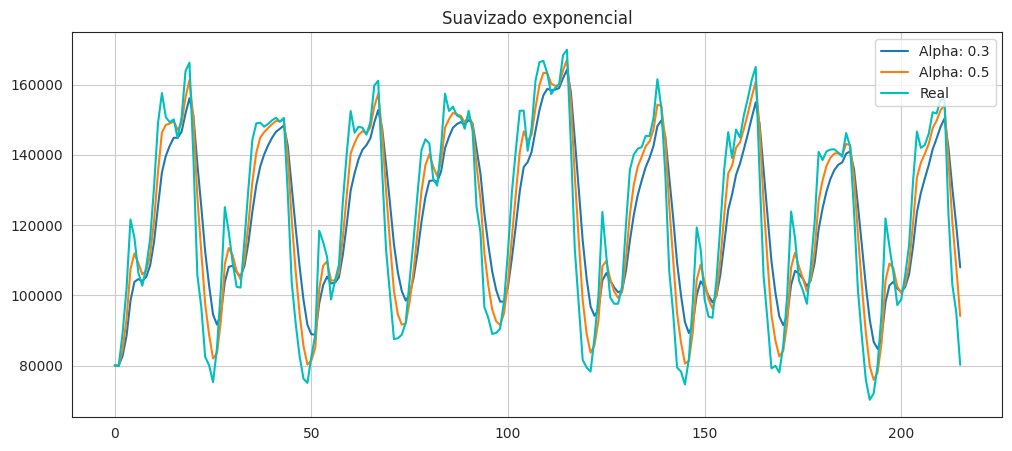

In [25]:
plot_exp_smoothing(ads.Ads, [0.3, 0.5])

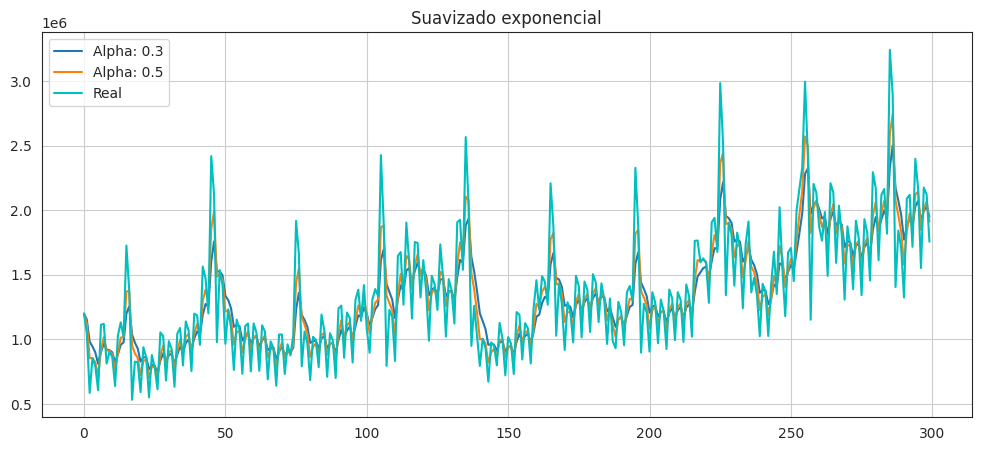

In [27]:
plot_exp_smoothing(cur.GEMS_GEMS_SPENT, [0.3, 0.5])